In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [27]:
bike_test=pd.read_excel('bike_test.xlsx')
bike_train=pd.read_excel('bike_train.xlsx')

In [6]:
def decompose_bike_sharing_demand(df, share_type='cnt', samples=250, period=24):
    if samples == 'all':
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

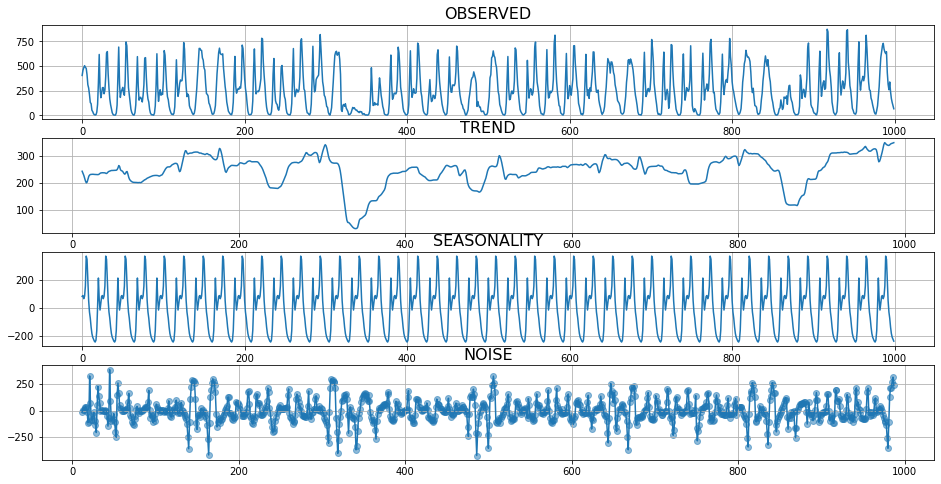

In [7]:
decompose_bike_sharing_demand(bike_train, samples=1000, period=24)

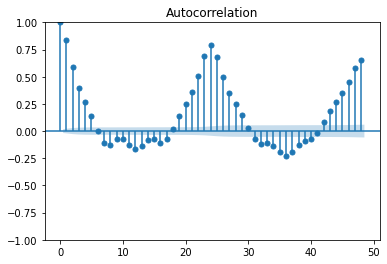

In [8]:
plot_acf(bike_train['cnt'].values, lags=48)
plt.show()

In [9]:
bike_train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,11995,2012-05-19,2,1,5,23,0,6,0,1,0.60,0.6212,0.56,0.1642,71,168,239
11995,11996,2012-05-20,2,1,5,0,0,0,0,1,0.58,0.5455,0.53,0.1045,42,128,170
11996,11997,2012-05-20,2,1,5,1,0,0,0,1,0.56,0.5303,0.52,0.0000,28,102,130
11997,11998,2012-05-20,2,1,5,2,0,0,0,1,0.56,0.5303,0.52,0.0000,36,62,98


In [28]:
bike_train['dteday'] = pd.to_datetime(bike_train['dteday'])
df = bike_train.set_index(bike_train.dteday)
df.drop('dteday', axis=1, inplace=True)
df.drop(['casual', 'registered','instant'], axis=1, inplace=True)

In [29]:
bike_test['dteday'] = pd.to_datetime(bike_test['dteday'])
bike_test = bike_test.set_index(bike_test.dteday)
bike_test.drop('dteday', axis=1, inplace=True)
bike_test.drop(['instant'], axis=1, inplace=True)

In [11]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,,
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-19,2,1,5,23,0,6,0,1,0.60,0.6212,0.56,0.1642,239
2012-05-20,2,1,5,0,0,0,0,1,0.58,0.5455,0.53,0.1045,170
2012-05-20,2,1,5,1,0,0,0,1,0.56,0.5303,0.52,0.0000,130


In [90]:
horizon=24*30
X = df.drop('cnt', axis=1)
y = df['cnt']
    
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
    
mae = np.round(mean_absolute_error(y_test, predictions), 3)    

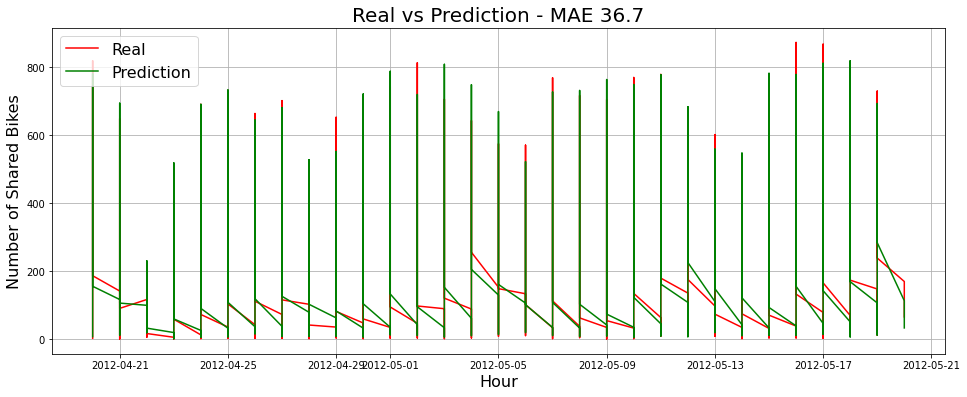

In [91]:
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_test, color='red')
plt.plot(pd.Series(predictions, index=y_test.index), color='green')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

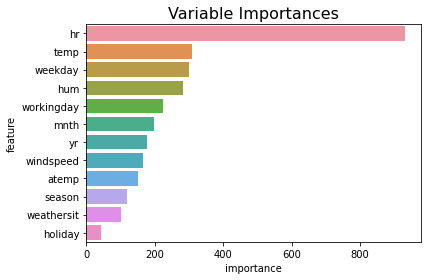

In [92]:
df_importances = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)
    
plt.title('Variable Importances', fontsize=16)
sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
plt.show()

In [93]:
predictionsf = model.predict(bike_test)
bike_predict=bike_test.copy(deep=True)
bike_predict['pred']=predictionsf

In [94]:
bike_predict.to_csv('Lizingrt.csv')